2nd one

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.utils import to_categorical
from sklearn.multiclass import OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
dataset_path = '/content/augmented_balanced_data_new.csv'
df = pd.read_csv(dataset_path)

# Specify the number of components for PCA
num_components = 20  # Adjust the number of components as needed

# Initialize PCA
pca = PCA(n_components=num_components)

# Initialize lists to store performance metrics across folds after PCA
mse_scores_ensemble_pca = []
accuracy_scores_ensemble_pca = []

# 'class' column contains the target variable
X = df.drop('attack_method', axis=1)  # Features
y = df['attack_method']  # Target

# Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Specify the number of splits for StratifiedKFold
num_splits = 5

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Initialize lists to store performance metrics across folds
mse_scores_stacked_ndae = []
accuracy_scores_stacked_ndae = []
mse_scores_sparse_autoencoder = []
accuracy_scores_sparse_autoencoder = []
mse_scores_stacked_autoencoder = []
accuracy_scores_stacked_autoencoder = []
mse_scores_ensemble = []
accuracy_scores_ensemble = []

# Initialize lists to store ROC curve values
all_fpr = []
mean_tpr = []

# Initialize list to store epoch losses
all_epoch_losses = []

# Loop over the folds for cross-validation
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X_scaled, y), 1):
    print(f"\nFold {fold}")

    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Define and train Stacked NDAE model using Keras
    model = Sequential()

    # Input layer with 41 units
    model.add(Dense(units=41, input_dim=X_train_cv.shape[1], activation='relu'))

    # First NDAE layer with 3 encoder layers
    model.add(Dense(units=12, activation='relu'))
    model.add(Dense(units=24, activation='relu'))
    model.add(Dense(units=24, activation='relu'))

    # Second NDAE layer with 3 encoder layers
    model.add(Dense(units=12, activation='relu'))
    model.add(Dense(units=24, activation='relu'))
    model.add(Dense(units=24, activation='relu'))

    # Third NDAE layer with 3 encoder layers
    model.add(Dense(units=12, activation='relu'))
    model.add(Dense(units=24, activation='relu'))
    model.add(Dense(units=24, activation='relu'))

    # Output layer
    model.add(Dense(units=X_train_cv.shape[1], activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Initialize list to store epoch losses for this fold
    epoch_losses = []

    # Train the model and collect epoch losses
    for epoch in range(15):
        history = model.fit(X_train_cv, X_train_cv, epochs=1, batch_size=128, shuffle=True, validation_data=(X_test_cv, X_test_cv))
        epoch_losses.append(history.history['loss'][0])

    all_epoch_losses.append(epoch_losses)

    # Evaluate the model on the test set
    mse_stacked_ndae, accuracy_stacked_ndae = model.evaluate(X_test_cv, X_test_cv)
    print(f'Mean Squared Error (Stacked NDAE): {mse_stacked_ndae}')
    print(f'Accuracy (Stacked NDAE): {accuracy_stacked_ndae}')

    mse_scores_stacked_ndae.append(mse_stacked_ndae)
    accuracy_scores_stacked_ndae.append(accuracy_stacked_ndae)

    # To obtain the encoded representations
    encoded_train_stacked_ndae = model.predict(X_train_cv)
    encoded_test_stacked_ndae = model.predict(X_test_cv)


    # Define and train Sparse Autoencoder model using Keras
    sae_model = Sequential()

    # Input layer
    sae_model.add(Dense(units=X_train_cv.shape[1], input_dim=X_train_cv.shape[1], activation='relu'))

    # Sparse Hidden layer with L1 regularization for sparsity
    sae_model.add(Dense(units=20, activation='relu', activity_regularizer=regularizers.l1(10e-5)))

    # Fully connected output layer with softmax activation for classification
    sae_model.add(Dense(units=len(np.unique(y)), activation='sigmoid'))

    # Compile the model
    sae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Convert labels to one-hot encoding
    y_train_cv_one_hot = to_categorical(y_train_cv)
    y_test_cv_one_hot = to_categorical(y_test_cv)

    # Train the model
    sae_model.fit(X_train_cv, y_train_cv_one_hot, epochs=15, batch_size=128, shuffle=True, validation_split=0.1)

    # Evaluate the model on the test set
    accuracy_sparse_autoencoder = sae_model.evaluate(X_test_cv, y_test_cv_one_hot)[1]
    print(f'Accuracy (Sparse Autoencoder): {accuracy_sparse_autoencoder}')

    accuracy_scores_sparse_autoencoder.append(accuracy_sparse_autoencoder)

    # Obtain encoded representations
    encoded_train_sparse = sae_model.predict(X_train_cv)
    encoded_test_sparse = sae_model.predict(X_test_cv)

    stacked_autoencoder = Sequential()

    # Input layer with 41 units
    stacked_autoencoder.add(Dense(units=41, input_dim=X_train_cv.shape[1], activation='relu'))

    # First NDAE layer with 3 encoder layers and 3 decoder layers
    stacked_autoencoder.add(Dense(units=12, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))

    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=12, activation='relu'))

    # Second NDAE layer with 3 encoder layers and 3 decoder layers
    stacked_autoencoder.add(Dense(units=12, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))

    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=12, activation='relu'))

    # Third NDAE layer with 3 encoder layers and 3 decoder layers
    stacked_autoencoder.add(Dense(units=12, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))

    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=24, activation='relu'))
    stacked_autoencoder.add(Dense(units=12, activation='relu'))



    # Compile the stacked autoencoder
    stacked_autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Convert labels to one-hot encoding
    y_train_cv_one_hot = to_categorical(y_train_cv)
    y_test_cv_one_hot = to_categorical(y_test_cv)

    # Output layer of the stacked autoencoder
    stacked_autoencoder.add(Dense(units=len(np.unique(y)), activation='sigmoid'))

    # Train the stacked autoencoder
    for epoch in range(15):  # Adjust the number of epochs as needed
        history = stacked_autoencoder.fit(X_train_cv, y_train_cv_one_hot, epochs=1, batch_size=128, shuffle=True, validation_data=(X_test_cv, y_test_cv_one_hot))
        epoch_losses.append(history.history['loss'][0])

    all_epoch_losses.append(epoch_losses)

    # Evaluate the model on the test set
    accuracy_stacked_autoencoder = stacked_autoencoder.evaluate(X_test_cv, y_test_cv_one_hot)[1]
    print(f'Accuracy (Stacked Autoencoder): {accuracy_stacked_autoencoder}')

    accuracy_scores_stacked_autoencoder.append(accuracy_stacked_autoencoder)

    # Obtain encoded representations
    encoded_train_stacked = stacked_autoencoder.predict(X_train_cv)
    encoded_test_stacked = stacked_autoencoder.predict(X_test_cv)

    # Combine encoded representations from all autoencoders
    encoded_train_ensemble = np.concatenate((encoded_train_stacked_ndae, encoded_train_sparse, encoded_train_stacked), axis=1)
    encoded_test_ensemble = np.concatenate((encoded_test_stacked_ndae, encoded_test_sparse, encoded_test_stacked), axis=1)
    encoded_train_ensemble_df = pd.DataFrame(encoded_train_ensemble)
    encoded_test_ensemble_df = pd.DataFrame(encoded_test_ensemble)

    print("Dimensions of encoded_train_ensemble_df:", encoded_train_ensemble_df.shape)

    # Apply PCA to encoded representations
    encoded_train_pca = pca.fit_transform(encoded_train_ensemble)
    encoded_test_pca = pca.transform(encoded_test_ensemble)
    encoded_train_pca_df = pd.DataFrame(encoded_train_pca)
    encoded_test_pca_df = pd.DataFrame(encoded_test_pca)

    print("Dimensions of encoded_train_pca_df:", encoded_train_pca_df.shape)


     # Initialize Random Forest classifier after PCA
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

    # Fit the Random Forest model after PCA
    rf_pca.fit(encoded_train_pca, y_train_cv)

    # Evaluate the Random Forest model on the test set after PCA
    y_pred_rf_pca = rf_pca.predict(encoded_test_pca)

    # Record performance metrics after PCA
    mse_rf_pca, accuracy_rf_pca = mean_squared_error(y_test_cv, y_pred_rf_pca), rf_pca.score(encoded_test_pca, y_test_cv)

    mse_scores_ensemble_pca.append(mse_rf_pca)
    accuracy_scores_ensemble_pca.append(accuracy_rf_pca)




Fold 1
504/504 [==============================] - 1s 2ms/step - loss: 0.7862 - accuracy: 0.1395
Mean Squared Error (Stacked NDAE): 0.7862045168876648
Accuracy (Stacked NDAE): 0.13951757550239563
504/504 [==============================] - 1s 2ms/step
Epoch 1/15
454/454 [==============================] - 2s 3ms/step - loss: 0.3778 - accuracy: 0.8899 - val_loss: 0.1204 - val_accuracy: 0.9688
Epoch 2/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0869 - accuracy: 0.9764 - val_loss: 0.0590 - val_accuracy: 0.9814
Epoch 3/15
454/454 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9849 - val_loss: 0.0432 - val_accuracy: 0.9868
Epoch 4/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0404 - accuracy: 0.9889 - val_loss: 0.0350 - val_accuracy: 0.9901
Epoch 5/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0332 - accuracy: 0.9912 - val_loss: 0.0306 - val_accuracy: 0.9919
Epoch 6/15
454/454 [===================

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load test dataset
test_dataset_path = '/content/encoded_best_test_data.csv'
df_test = pd.read_csv(test_dataset_path)

# Extract features and target from the testing dataset
X_test = df_test.drop('attack_method', axis=1)
y_test = df_test['attack_method']

# Preprocess the testing data using the same scaler used for training data
X_test_scaled = scaler.transform(X_test)

# Obtain encoded representations for the testing data using the trained autoencoders
encoded_test_stacked_ndae = model.predict(X_test_scaled)
encoded_test_sparse = sae_model.predict(X_test_scaled)
encoded_test_stacked = stacked_autoencoder.predict(X_test_scaled)

# Combine encoded representations from all autoencoders
encoded_test_ensemble = np.concatenate((encoded_test_stacked_ndae, encoded_test_sparse, encoded_test_stacked), axis=1)

# Apply PCA to encoded representations for testing data
encoded_test_pca = pca.transform(encoded_test_ensemble)

# Use the trained SVM model after PCA to make predictions on the testing data
y_pred_test_pca = rf_pca.predict(encoded_test_pca)

# Calculate accuracy, precision, recall, and F1 score
accuracy_test_pca = accuracy_score(y_test, y_pred_test_pca)
precision_test_pca = precision_score(y_test, y_pred_test_pca, average='weighted')
recall_test_pca = recall_score(y_test, y_pred_test_pca, average='weighted')
f1_test_pca = f1_score(y_test, y_pred_test_pca, average='weighted')

# Display accuracy, precision, recall, and F1 score
print(f'Accuracy (Testing): {accuracy_test_pca}')
print(f'Precision (Testing): {precision_test_pca}')
print(f'Recall (Testing): {recall_test_pca}')
print(f'F1 Score (Testing): {f1_test_pca}')

# Convert labels to binary format for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=list(set(y_test)))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test_pca)

# Plot confusion matrix and bar graph
plt.figure(figsize= (15, 6))



929/929 [==============================] - 2s 2ms/step
Accuracy (Testing): 0.9978454080258551
Precision (Testing): 0.997519807990215
Recall (Testing): 0.9974607214261269
F1 Score (Testing): 9976522197542442



Metrics for Ddos:
Accuracy: 99.80%

Metrics for Normal:
Accuracy: 99.91%

Metrics for Probe:
Accuracy: 99.78%

Metrics for R2l:
Accuracy: 99.52%

Metrics for U2r:
Accuracy: 81.82%


<ipython-input-5-c44977824dc2>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_per_label.keys()), y=accuracy_per_label, palette="viridis")


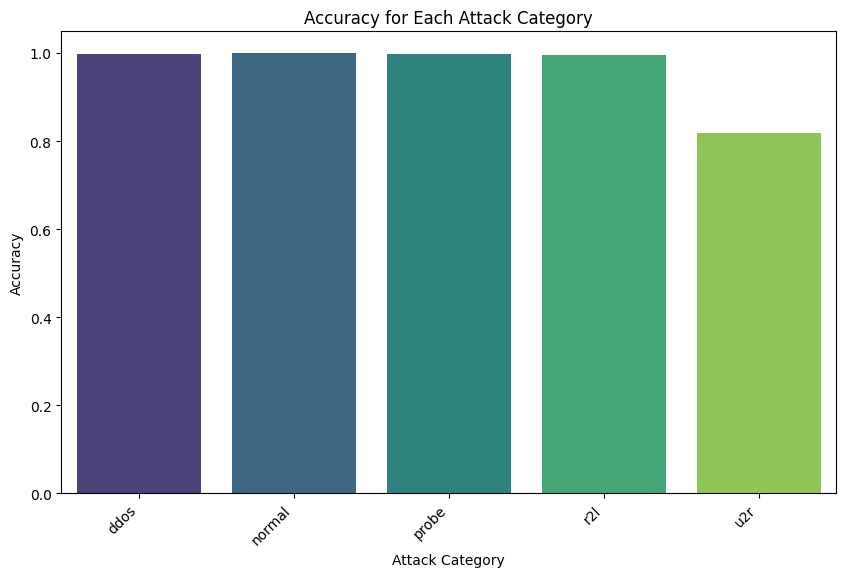

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 5, does not match size of target_names, 6
  warnings.warn(



Overall Metrics:
              precision    recall  f1-score   support

        ddos     0.9994    0.9980    0.9987     10814
      normal     0.9997    0.9991    0.9994     15763
       probe     0.9948    0.9978    0.9963      2669
         r2l     0.9721    0.9952    0.9835       420
         u2r     0.6000    0.8182    0.6923        22

    accuracy                         0.9984     29688
   macro avg     0.9132    0.9616    0.9340     29688
weighted avg     0.9985    0.9984    0.9984     29688



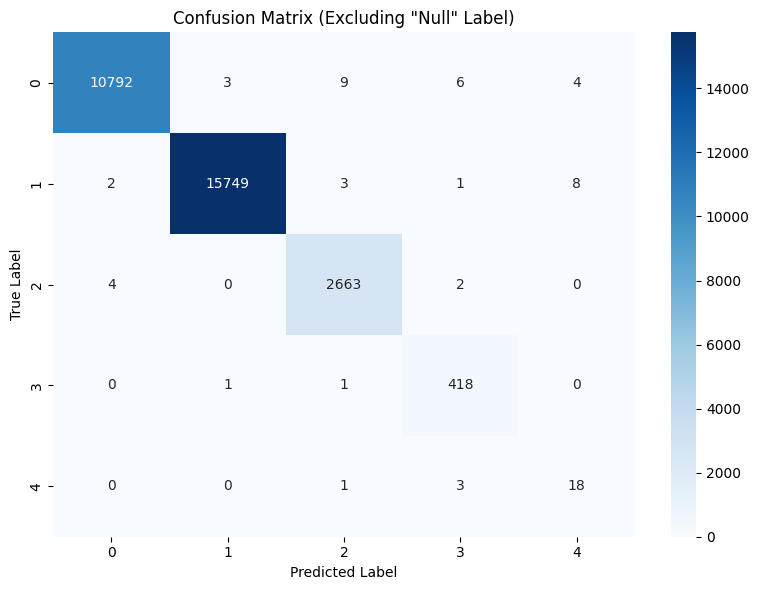

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'labels' is the array of unique labels in the dataset
unique_labels = np.unique(y_test)

# Calculate metrics for each attack category
metrics_per_label = {}
accuracy_per_label = []

for label in unique_labels:
    if label == 5:  # Skip the "null" label
        continue

    indices = y_test == label
    true_labels = y_test[indices]
    predicted_labels = y_pred_test_pca[indices]

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

    attack_category = label_mapping.get(label, f'Unknown Label {label}')
    metrics_per_label[attack_category] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    accuracy_per_label.append(accuracy)
    print(f"\nMetrics for {attack_category.capitalize()}:")
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot bar graph for accuracy of each label
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics_per_label.keys()), y=accuracy_per_label, palette="viridis")
plt.xlabel('Attack Category')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Attack Category')
plt.xticks(rotation=45, ha='right')
plt.show()

# Filter out "null" label from overall metrics and confusion matrix
filtered_indices = y_test != 5
overall_report = classification_report(y_test[filtered_indices], y_pred_test_pca[filtered_indices],
                                       labels=[0, 1, 2, 3, 4], target_names=label_mapping.values(), digits=4)
print("\nOverall Metrics:")
print(overall_report)

# Calculate confusion matrix for the overall dataset (excluding "null" label)
conf_matrix_overall = confusion_matrix(y_test[filtered_indices], y_pred_test_pca[filtered_indices])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_overall, annot=True, fmt="d", cmap="Blues", xticklabels=np.delete(unique_labels, 5),
            yticklabels=np.delete(unique_labels, 5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
